In [1]:
import pandas as pd
import scipy
import numpy as np
import scipy.sparse as sp
import scipy.io as spio

from scipy.stats import pearsonr

import operator
import matplotlib.pyplot as plt

import matplotlib.cm as cm
import matplotlib.colors as colors

import matplotlib as mpl
from matplotlib.text import TextPath
from matplotlib.patches import PathPatch, Rectangle
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
from matplotlib.ticker import FormatStrFormatter
from sklearn.metrics import roc_auc_score

import seaborn as sns
import matplotlib.collections as collections

import isolearn.io as isoio

from analyze_aparent_designed_mpra_helpers import *


<h2>Load collapsed designed MPRA data</h2>

In [2]:
#Load designed MPRA data (Collapsed over experiment replicates)
seq_dict = isoio.load('../data/prepared_data/apa_array_data/apa_array_data_master_seq')
print("n = " + str(len(seq_dict['array_df'])))
print('Avg read count (avg over barcodes) = ' + str(np.mean(seq_dict['array_df'].query("n_barcodes >= 2")['mean_total_count'])))
print('Pooled read count (pooled over barcodes) = ' + str(np.mean(seq_dict['array_df'].query("n_barcodes >= 2")['pooled_total_count'])))

#Load variant dataframe
variant_dict = isoio.load('../data/prepared_data/apa_variant_data/apa_variant_data_master_seq')
print("n (variants) = " + str(len(variant_dict['variant_df'])))

#Load predictions
model_name = 'aparent_theano_legacy_30_31_34_pasaligned'
pred_dict = isoio.load('predictions/apa_array_data_legacy/' + model_name + '_predictions_master_seq')

#Join mpra dataframes with prediction table and calculate cut probabilities
seq_df, variant_df = append_predictions(seq_dict['array_df'], seq_dict['pooled_cuts'], variant_dict['variant_df'], variant_dict['pooled_cuts_var'], variant_dict['pooled_cuts_ref'], pred_dict['array_df'], pred_dict['cut_prob'])


n = 39833
Avg read count (avg over barcodes) = 431.92676310713546
Pooled read count (pooled over barcodes) = 3656.5562880452626
n (variants) = 21734


<h2>Detailed SeqProp Target/Max Cut analysis</h2>

In [3]:
unique_experiments = seq_df.query("experiment == 'max_cut'")['subexperiment'].unique()

seq_df_filtered = seq_df.query("mean_total_count >= 100 and n_barcodes >= 5")

cut_df_filtered = seq_df.query("experiment == 'max_cut' and mean_total_count >= 10").copy()

#Map and evaluate sequences
def eval_logloss(cut_prob, target_pos) :
    target = np.zeros(cut_prob.shape[0])
    target[target_pos] = 0.8
    target[target_pos - 1] = 0.10
    target[target_pos + 1] = 0.10
    
    ent = -np.dot(target, np.log((cut_prob + 0.001) / np.sum(cut_prob + 0.001)))
    
    return ent

start_pos = 58
end_pos = 108

cut_poses = np.arange(end_pos - start_pos) + (start_pos - 56)

true_cut_column = 'cut_prob_true'
pred_cut_column = 'cut_prob_pred'

avg_position_true = []
avg_position_pred = []
cut_probs_true = []
cut_probs_pred = []
log_loss = []
for index, row in cut_df_filtered.iterrows() :
    
    cut_prob_true = np.ravel(row[true_cut_column])
    cut_prob_true = cut_prob_true[start_pos:end_pos] / np.sum(cut_prob_true[start_pos:end_pos])
    cut_probs_true.append(cut_prob_true)

    cut_prob_pred = np.ravel(row[pred_cut_column])
    cut_prob_pred = cut_prob_pred[start_pos:end_pos] / np.sum(cut_prob_pred[start_pos:end_pos])
    cut_probs_pred.append(cut_prob_pred)
    
    avg_pos_true = np.dot(cut_prob_true, (np.arange(cut_prob_true.shape[0]) + start_pos))
    avg_pos_pred = np.dot(cut_prob_pred, (np.arange(cut_prob_pred.shape[0]) + start_pos))
    avg_position_true.append(avg_pos_true)
    avg_position_pred.append(avg_pos_pred)
    
    cut_pos_caught = False
    for cut_pos in [60, 65, 70, 75, 80, 85, 90, 95, 100] :
        if str(cut_pos) in row['subexperiment'] :            
            log_loss.append(eval_logloss(np.copy(cut_prob_true), cut_pos - 55 - (start_pos - 56)))
            
            cut_pos_caught = True
            break
    
    if not cut_pos_caught :
        log_loss.append(0)
    

cut_df_filtered['proxcut_prob_true'] = cut_probs_true
cut_df_filtered['proxcut_prob_pred'] = cut_probs_pred
cut_df_filtered['avgpos_true'] = avg_position_true
cut_df_filtered['avgpos_pred'] = avg_position_pred
cut_df_filtered['loss_logloss'] = log_loss

cut_snv_df_filtered = cut_df_filtered.query("variant == 'snv'").copy()
cut_df_filtered = cut_df_filtered.query("variant != 'snv'").copy()

print("Total number of Max Cut sequences = " + str(len(cut_df_filtered)))


df_human = seq_df_filtered.query("experiment == 'clinvar_wt' and variant == 'wt'")
human_cutprobs = np.array(df_human[true_cut_column].values.tolist())[:, start_pos:end_pos]
human_cutprobs = human_cutprobs / np.sum(human_cutprobs, axis=1).reshape(-1, 1)

human_cutprob = np.mean(human_cutprobs, axis=0)

objective_poses = [5, 10, 15, 20, 25, 30, 35, 40, 45]

Total number of Max Cut sequences = 1274


<h2>Detailed Max Cut analysis</h2>

In [4]:
max_cut_pwm_dict, max_cut_yhat_dict = load_max_cut_pwms()


In [5]:
#Un-comment to generate Max Cut- sequences for folding

#Max Cut Sequences
#cut_df_filtered['fold_pos'] = cut_df_filtered['subexperiment'].apply(lambda exp: int(exp.split('_')[-1]) + 1)
#cut_df_filtered.reset_index()[['master_seq', 'fold_pos']].to_csv('folding/array_maxcut_seqs.csv', sep=',', index=False)

#Max Cut SNV Sequences
#cut_snv_df_filtered['fold_pos'] = cut_snv_df_filtered['subexperiment'].apply(lambda exp: int(exp.split('_')[-1]) + 1)
#cut_snv_df_filtered.reset_index()[['master_seq', 'fold_pos']].to_csv('folding/array_maxcut_snv_seqs.csv', sep=',', index=False)


In [6]:
#Read folded Max Cut- sequences
cut_fold_df = pd.read_csv('folding/array_maxcut_seqs_folded.csv', sep=',')[['master_seq', 'mfe', 'struct']].set_index('master_seq')
cut_df_filtered_folded = cut_df_filtered.join(cut_fold_df, on='master_seq', how='inner')

#Read folded Mac Cut SNV- sequences
cut_snv_fold_df = pd.read_csv('folding/array_maxcut_snv_seqs_folded.csv', sep=',')[['master_seq', 'mfe', 'struct']].set_index('master_seq')
cut_snv_df_filtered_folded = cut_snv_df_filtered.join(cut_snv_fold_df, on='master_seq', how='inner')
cut_snv_df_filtered_folded = cut_snv_df_filtered_folded.join(cut_df_filtered_folded.set_index('master_seq'), on='wt_seq', how='inner', rsuffix='_wt')

<h2>Best Max Cut sequences ('A' subexperiment)</h2>

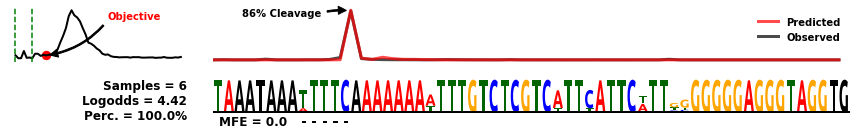

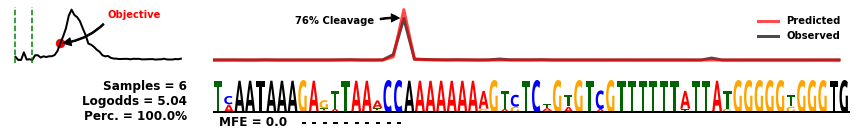

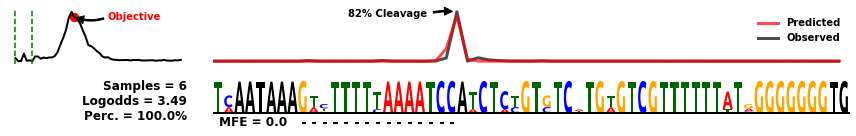

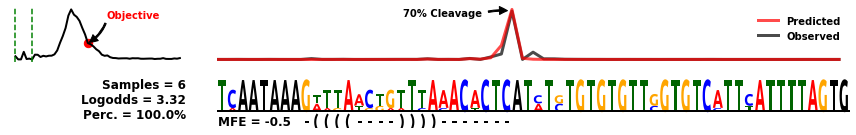

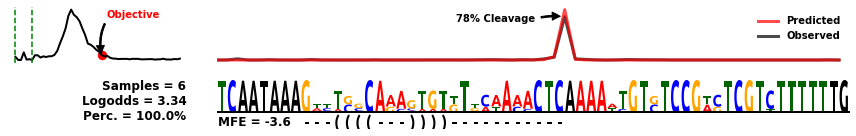

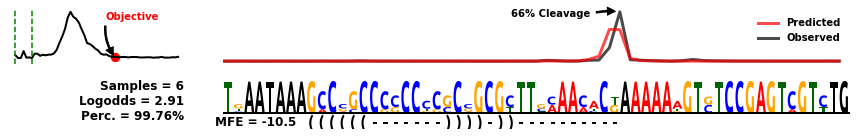

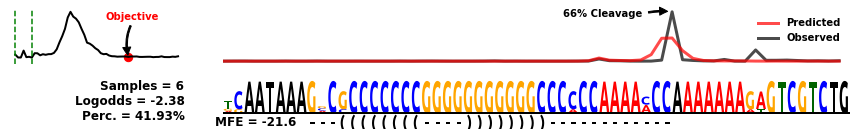

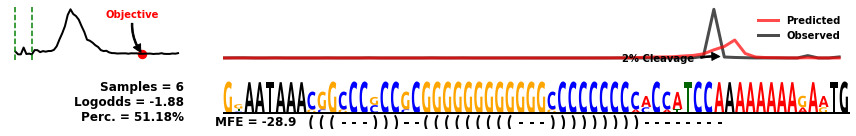

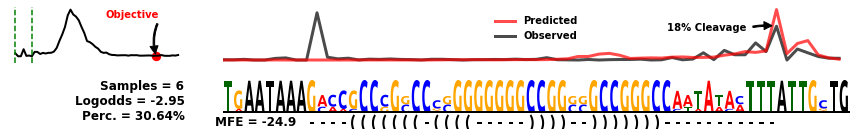

In [7]:

df_human = seq_df_filtered.query("experiment == 'clinvar_wt' and variant == 'wt'")

cut_nt = 'A'
aruns_objective = ''
ggcc_objective = '_GGCC'
subexperiments = [
    [cut_nt + aruns_objective + '_60'],#, cut_nt + aruns_objective + '_ent_60'
    [cut_nt + aruns_objective + '_65'],#, cut_nt + aruns_objective + '_ent_65'],
    [cut_nt + aruns_objective + '_70'],#, cut_nt + aruns_objective + '_ent_70'],
    [cut_nt + aruns_objective + '_75'],#, cut_nt + aruns_objective + '_ent_75'],
    [cut_nt + aruns_objective + '_80'],#, cut_nt + aruns_objective + '_ent_80'],
    [cut_nt + ggcc_objective + aruns_objective + '_85'],#, cut_nt + ggcc_objective + aruns_objective + '_ent_85'],
    [cut_nt + ggcc_objective + aruns_objective + '_90'],#, cut_nt + ggcc_objective + aruns_objective + '_ent_90'],
    [cut_nt + ggcc_objective + aruns_objective + '_95'],#, cut_nt + ggcc_objective + aruns_objective + '_ent_95'],
    [cut_nt + ggcc_objective + aruns_objective + '_100'],#, cut_nt + ggcc_objective + aruns_objective + '_ent_100'],
]


true_column='median_proximal_vs_distal_logodds_true'
cut_column='cut_prob_true'

usage_unit = 'log'

plot_mean_logo=False
plot_max_logo=True
plot_actual_pwm=True
plot_opt_pwm=False

black_fixed_seq=True

#plot_start=15
#plot_end=110
#figsize=(14,2)
#width_ratios=[2, 1, 14]
#logo_height = 0.85
plot_start=48
plot_end=108
figsize=(12,2)
width_ratios=[4, 1, 14]
logo_height = 0.85

plot_percentile=True
override_mean_stats=False

max_index=0
normalize_probs = True
normalize_range = [plot_start, plot_end]#None
agg_mode = 'avg'

annotate_peaks=True

plot_mfe=True
fold_height=0.7

save_figs=False

for i, subexperiment in enumerate(subexperiments) :
    plot_cut_logo(cut_df_filtered_folded.query("gene == 'simple'").reset_index(), df_human, max_cut_pwm_dict, max_cut_yhat_dict, 'simple', subexperiment, plot_mfe=plot_mfe, fold_height=fold_height, annotate_peaks=annotate_peaks, normalize_probs=normalize_probs, normalize_range=normalize_range, agg_mode=agg_mode, override_mean_stats=override_mean_stats, plot_percentile=plot_percentile, plot_mean_logo=plot_mean_logo, plot_max_logo=plot_max_logo, plot_actual_pwm=plot_actual_pwm, plot_opt_pwm=plot_opt_pwm, black_fixed_seq=black_fixed_seq, max_index=max_index, true_column=true_column, cut_column=cut_column, figsize=figsize, width_ratios=width_ratios, logo_height=logo_height, usage_unit=usage_unit, plot_snvs=False, seq_trim_start=0, seq_trim_end=164, plot_start=plot_start, plot_end=plot_end, pas_downscaling=1.0, save_figs=save_figs, fig_name='max_cut_' + subexperiment[0], fig_dpi=300)

<h2>Best Max Cut sequences ('AT' subexperiment)</h2>

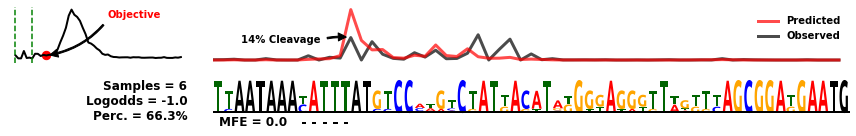

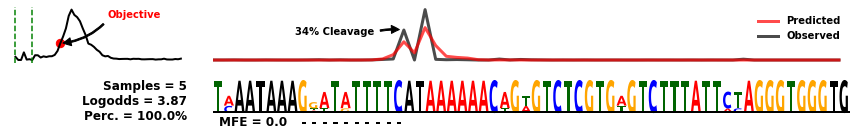

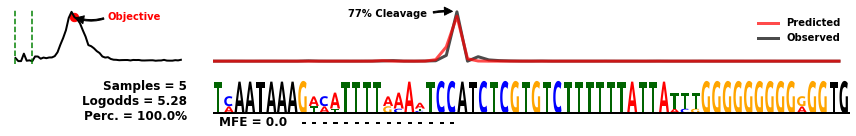

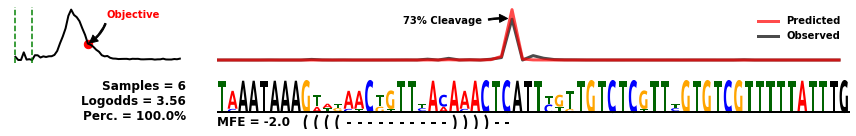

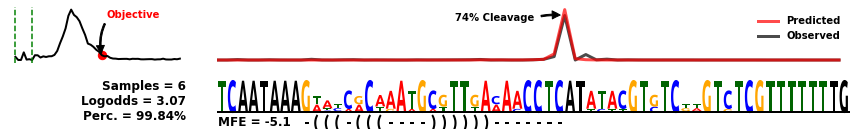

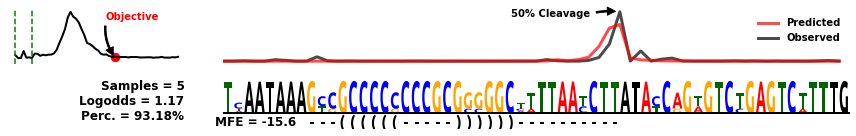

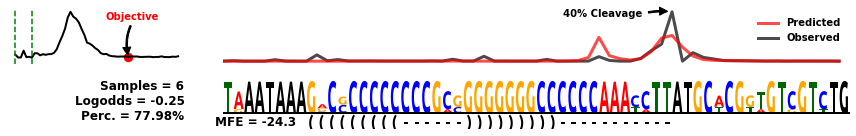

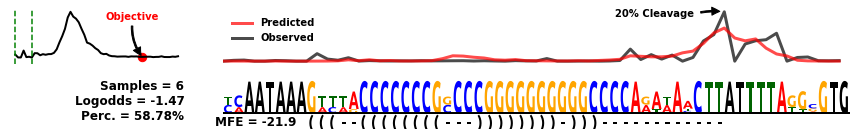

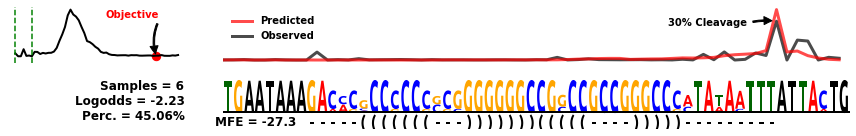

In [8]:

df_human = seq_df_filtered.query("experiment == 'clinvar_wt' and variant == 'wt'")

cut_nt = 'AT'
aruns_objective = ''
ggcc_objective = '_GGCC'
subexperiments = [
    [cut_nt + aruns_objective + '_60'],#, cut_nt + aruns_objective + '_ent_60'
    [cut_nt + aruns_objective + '_65'],#, cut_nt + aruns_objective + '_ent_65'],
    [cut_nt + aruns_objective + '_70'],#, cut_nt + aruns_objective + '_ent_70'],
    [cut_nt + aruns_objective + '_75'],#, cut_nt + aruns_objective + '_ent_75'],
    [cut_nt + aruns_objective + '_80'],#, cut_nt + aruns_objective + '_ent_80'],
    [cut_nt + ggcc_objective + aruns_objective + '_85'],#, cut_nt + ggcc_objective + aruns_objective + '_ent_85'],
    [cut_nt + ggcc_objective + aruns_objective + '_90'],#, cut_nt + ggcc_objective + aruns_objective + '_ent_90'],
    [cut_nt + ggcc_objective + aruns_objective + '_95'],#, cut_nt + ggcc_objective + aruns_objective + '_ent_95'],
    [cut_nt + ggcc_objective + aruns_objective + '_100'],#, cut_nt + ggcc_objective + aruns_objective + '_ent_100'],
]


true_column='median_proximal_vs_distal_logodds_true'
cut_column='cut_prob_true'

usage_unit = 'log'

plot_mean_logo=False
plot_max_logo=True
plot_actual_pwm=True
plot_opt_pwm=False

black_fixed_seq=True

#plot_start=15
#plot_end=110
#figsize=(14,2)
#width_ratios=[2, 1, 14]
#logo_height = 0.85
plot_start=48
plot_end=108
figsize=(12,2)
width_ratios=[4, 1, 14]
logo_height = 0.85

plot_percentile=True
override_mean_stats=False

max_index=0
normalize_probs = True
normalize_range = [plot_start, plot_end]#None
agg_mode = 'avg'

annotate_peaks=True

plot_mfe=True
fold_height=0.7

save_figs=False

for i, subexperiment in enumerate(subexperiments) :
    plot_cut_logo(cut_df_filtered_folded.query("gene == 'simple'").reset_index(), df_human, max_cut_pwm_dict, max_cut_yhat_dict, 'simple', subexperiment, plot_mfe=plot_mfe, fold_height=fold_height, annotate_peaks=annotate_peaks, normalize_probs=normalize_probs, normalize_range=normalize_range, agg_mode=agg_mode, override_mean_stats=override_mean_stats, plot_percentile=plot_percentile, plot_mean_logo=plot_mean_logo, plot_max_logo=plot_max_logo, plot_actual_pwm=plot_actual_pwm, plot_opt_pwm=plot_opt_pwm, black_fixed_seq=black_fixed_seq, max_index=max_index, true_column=true_column, cut_column=cut_column, figsize=figsize, width_ratios=width_ratios, logo_height=logo_height, usage_unit=usage_unit, plot_snvs=False, seq_trim_start=0, seq_trim_end=164, plot_start=plot_start, plot_end=plot_end, pas_downscaling=1.0, save_figs=save_figs, fig_name='max_cut_' + subexperiment[0], fig_dpi=300)

<h2>Best Max Cut sequences ('Punish A-runs' subexperiment)</h2>

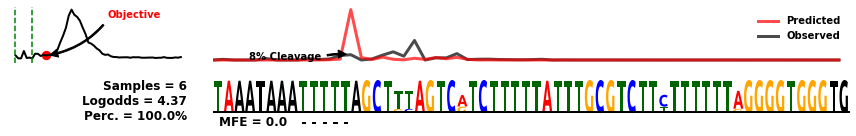

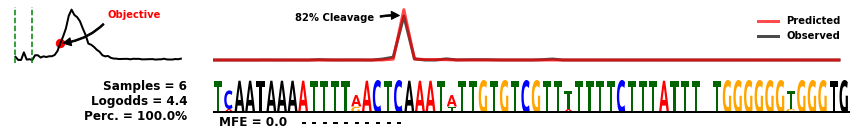

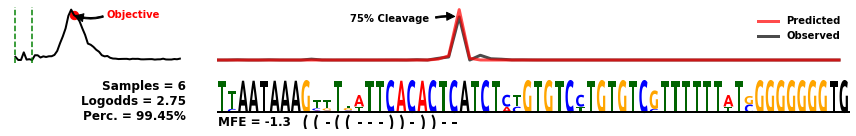

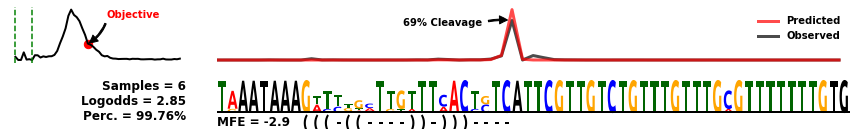

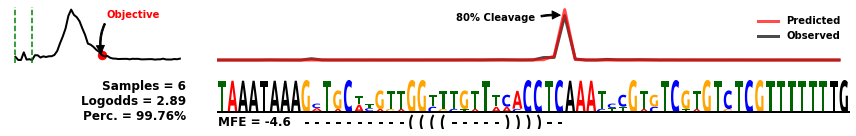

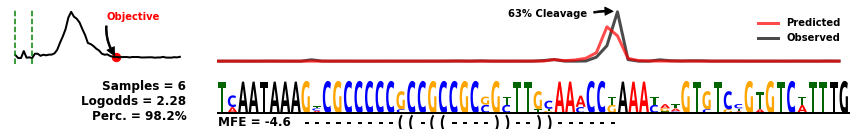

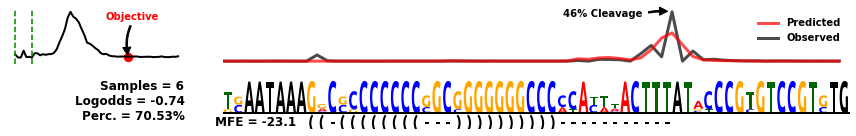

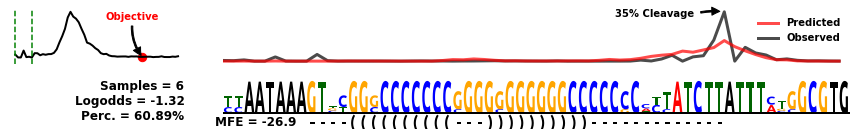

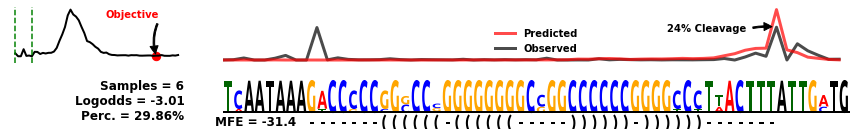

In [9]:

df_human = seq_df_filtered.query("experiment == 'clinvar_wt' and variant == 'wt'")

cut_nt = 'A'
aruns_objective = '_aruns'
ggcc_objective = '_GGCC'
subexperiments = [
    [cut_nt + aruns_objective + '_60'],#, cut_nt + aruns_objective + '_ent_60'
    [cut_nt + aruns_objective + '_65'],#, cut_nt + aruns_objective + '_ent_65'],
    [cut_nt + aruns_objective + '_70'],#, cut_nt + aruns_objective + '_ent_70'],
    [cut_nt + aruns_objective + '_75'],#, cut_nt + aruns_objective + '_ent_75'],
    [cut_nt + aruns_objective + '_80'],#, cut_nt + aruns_objective + '_ent_80'],
    [cut_nt + ggcc_objective + aruns_objective + '_85'],#, cut_nt + ggcc_objective + aruns_objective + '_ent_85'],
    [cut_nt + ggcc_objective + aruns_objective + '_90'],#, cut_nt + ggcc_objective + aruns_objective + '_ent_90'],
    [cut_nt + ggcc_objective + aruns_objective + '_95'],#, cut_nt + ggcc_objective + aruns_objective + '_ent_95'],
    [cut_nt + ggcc_objective + aruns_objective + '_100'],#, cut_nt + ggcc_objective + aruns_objective + '_ent_100'],
]


true_column='median_proximal_vs_distal_logodds_true'
cut_column='cut_prob_true'

usage_unit = 'log'

plot_mean_logo=False
plot_max_logo=True
plot_actual_pwm=True
plot_opt_pwm=False

black_fixed_seq=True

#plot_start=15
#plot_end=110
#figsize=(14,2)
#width_ratios=[2, 1, 14]
#logo_height = 0.85
plot_start=48
plot_end=108
figsize=(12,2)
width_ratios=[4, 1, 14]
logo_height = 0.85

plot_percentile=True
override_mean_stats=False

max_index=0
normalize_probs = True
normalize_range = [plot_start, plot_end]#None
agg_mode = 'avg'

annotate_peaks=True

plot_mfe=True
fold_height=0.7

save_figs=False

for i, subexperiment in enumerate(subexperiments) :
    plot_cut_logo(cut_df_filtered_folded.query("gene == 'simple'").reset_index(), df_human, max_cut_pwm_dict, max_cut_yhat_dict, 'simple', subexperiment, plot_mfe=plot_mfe, fold_height=fold_height, annotate_peaks=annotate_peaks, normalize_probs=normalize_probs, normalize_range=normalize_range, agg_mode=agg_mode, override_mean_stats=override_mean_stats, plot_percentile=plot_percentile, plot_mean_logo=plot_mean_logo, plot_max_logo=plot_max_logo, plot_actual_pwm=plot_actual_pwm, plot_opt_pwm=plot_opt_pwm, black_fixed_seq=black_fixed_seq, max_index=max_index, true_column=true_column, cut_column=cut_column, figsize=figsize, width_ratios=width_ratios, logo_height=logo_height, usage_unit=usage_unit, plot_snvs=False, seq_trim_start=0, seq_trim_end=164, plot_start=plot_start, plot_end=plot_end, pas_downscaling=1.0, save_figs=save_figs, fig_name='max_cut_' + subexperiment[0], fig_dpi=300)

<h2>Max Cut sequences with Saturation Mutagenesis measurements</h2>

9


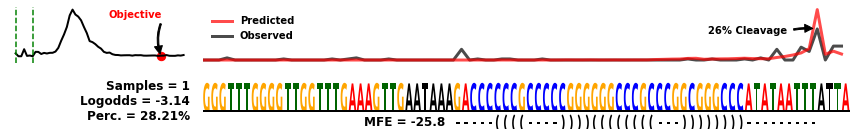

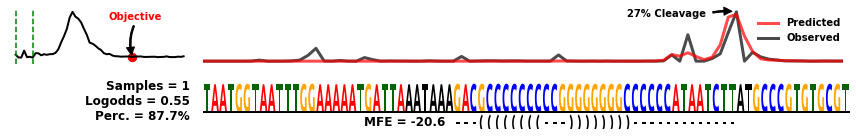

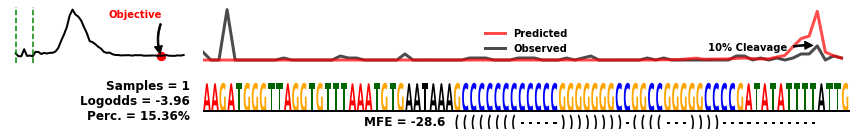

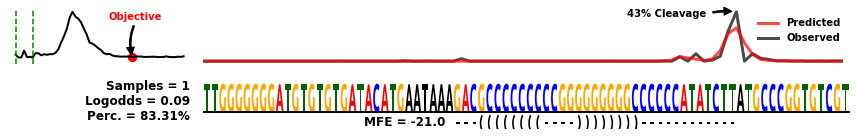

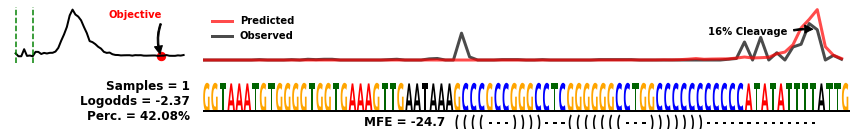

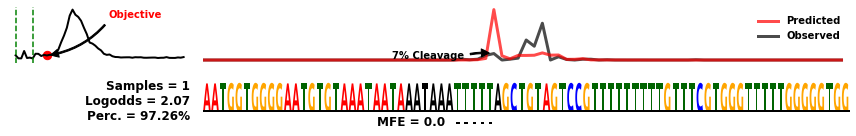

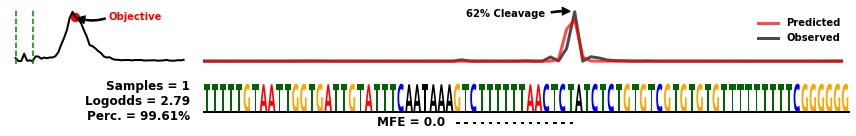

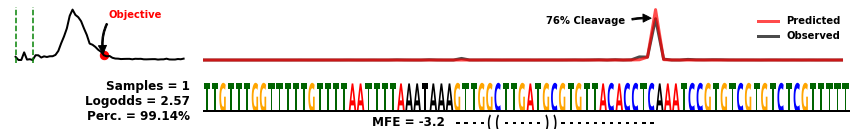

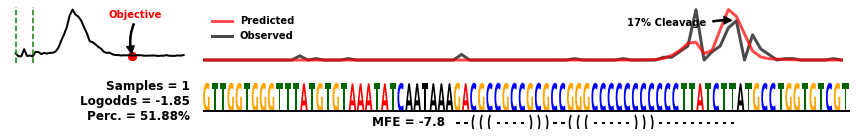

In [10]:
df_human = seq_df_filtered.query("experiment == 'clinvar_wt' and variant == 'wt'")

true_column='median_proximal_vs_distal_logodds_true'
cut_column='cut_prob_true'

usage_unit = 'log'

plot_mean_logo=False
plot_max_logo=True
plot_actual_pwm=True
plot_opt_pwm=False

black_fixed_seq=True

plot_start=25
plot_end=105
figsize=(12,2)
width_ratios=[4, 1, 14]
logo_height = 0.75

plot_percentile=True
override_mean_stats=False

max_index=0
normalize_probs = True
normalize_range = [plot_start, plot_end]#None
agg_mode = 'avg'

annotate_peaks=True

plot_mfe=True
fold_height=0.7

save_figs=False

snv_distinct_seqs = cut_snv_df_filtered['wt_seq'].unique()

cut_df_filtered_folded_sel = cut_df_filtered_folded.loc[cut_df_filtered_folded.wt_seq.isin(snv_distinct_seqs)]
print(len(cut_df_filtered_folded_sel))

for subexperiment_i, subexperiment in enumerate(sorted(cut_snv_df_filtered['subexperiment'].unique())) :

    plot_cut_logo(cut_df_filtered_folded_sel.query("gene == 'simple'").reset_index(), df_human, max_cut_pwm_dict, max_cut_yhat_dict, 'simple', [subexperiment], plot_mfe=plot_mfe, fold_height=fold_height, annotate_peaks=annotate_peaks, normalize_probs=normalize_probs, normalize_range=normalize_range, agg_mode=agg_mode, override_mean_stats=override_mean_stats, plot_percentile=plot_percentile, plot_mean_logo=plot_mean_logo, plot_max_logo=plot_max_logo, plot_actual_pwm=plot_actual_pwm, plot_opt_pwm=plot_opt_pwm, black_fixed_seq=black_fixed_seq, max_index=max_index, true_column=true_column, cut_column=cut_column, figsize=figsize, width_ratios=width_ratios, logo_height=logo_height, usage_unit=usage_unit, plot_snvs=False, seq_trim_start=0, seq_trim_end=164, plot_start=plot_start, plot_end=plot_end, pas_downscaling=1.0, save_figs=save_figs, fig_name='max_cut_' + subexperiment, fig_dpi=300)


<h2>Saturation Mutagenesis of a CSE+35 optimized Max Cut Sequence</h2>

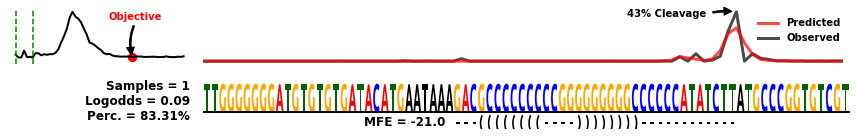

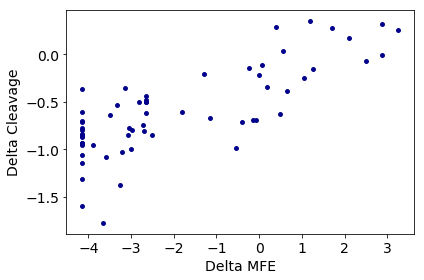

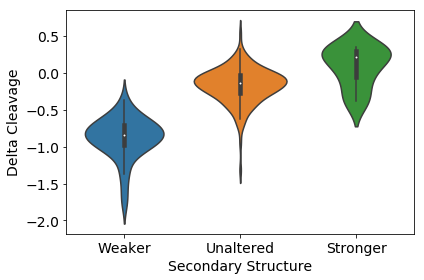

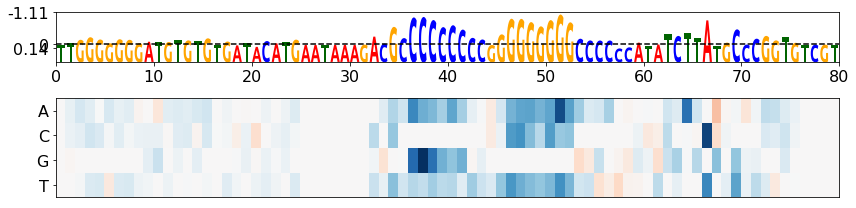

In [11]:
df_human = seq_df_filtered.query("experiment == 'clinvar_wt' and variant == 'wt'")

cut_nt = 'A'
aruns_objective = '_aruns'
ggcc_objective = '_GGCC'
subexperiment = [cut_nt + ggcc_objective + aruns_objective + '_ent_90']

true_column='median_proximal_vs_distal_logodds_true'
cut_column='cut_prob_true'
pred_cut_column='cut_prob_pred'

usage_unit = 'log'

plot_mean_logo=False
plot_max_logo=True
plot_actual_pwm=True
plot_opt_pwm=False

black_fixed_seq=True

plot_start=25
plot_end=105
figsize=(12,2)
width_ratios=[4, 1, 14]
logo_height = 0.75

plot_percentile=True
override_mean_stats=False

max_index=0
normalize_probs = True
normalize_range = [plot_start, plot_end]
agg_mode = 'avg'

annotate_peaks=True

plot_mfe=True
fold_height=0.7

save_figs=False

snv_distinct_seqs = cut_snv_df_filtered['wt_seq'].unique()

cut_df_filtered_folded_sel = cut_df_filtered_folded.loc[cut_df_filtered_folded.wt_seq.isin(snv_distinct_seqs)]

plot_cut_logo(cut_df_filtered_folded_sel.query("gene == 'simple'").reset_index(), df_human, max_cut_pwm_dict, max_cut_yhat_dict, 'simple', subexperiment, plot_mfe=plot_mfe, fold_height=fold_height, annotate_peaks=annotate_peaks, normalize_probs=normalize_probs, normalize_range=normalize_range, agg_mode=agg_mode, override_mean_stats=override_mean_stats, plot_percentile=plot_percentile, plot_mean_logo=plot_mean_logo, plot_max_logo=plot_max_logo, plot_actual_pwm=plot_actual_pwm, plot_opt_pwm=plot_opt_pwm, black_fixed_seq=black_fixed_seq, max_index=max_index, true_column=true_column, cut_column=cut_column, figsize=figsize, width_ratios=width_ratios, logo_height=logo_height, usage_unit=usage_unit, plot_snvs=False, seq_trim_start=0, seq_trim_end=164, plot_start=plot_start, plot_end=plot_end, pas_downscaling=1.0, save_figs=save_figs, fig_name='max_cut_' + subexperiment[0], fig_dpi=300)

wt_seq = cut_snv_df_filtered_folded.query("subexperiment == '" + subexperiment[0] + "'")['wt_seq'].unique()[0]

snv_df = cut_snv_df_filtered_folded.loc[cut_snv_df_filtered_folded.wt_seq.str.contains(wt_seq)].copy()

obj_pos = int(subexperiment[0].split("_")[-1])

#Map SNV positions
snv_poses = []
for index, row in snv_df.iterrows() :
    
    snv_pos = -1
    seq = row['master_seq']
    wt_seq = row['wt_seq']
    
    for j in range(0, len(seq)) :
        if seq[j] != wt_seq[j] :
            snv_pos = j
            break
    
    snv_poses.append(snv_pos)

snv_df['snv_pos'] = snv_poses

snv_df = snv_df.query("((snv_pos > 0 and snv_pos < 50) or (snv_pos > 56 and snv_pos < 105))")# and snv_pos != " + str(obj_pos + 1))

#Calculate true variant and wt cut log odds
snv_df['norm_cuts'] = snv_df[cut_column].apply(lambda c: c[:plot_end] / np.sum(c[:plot_end]))
snv_df['cut_logodds'] = snv_df['norm_cuts'].apply(lambda c: np.sum(c[obj_pos:obj_pos+2]))
snv_df['cut_logodds'] = np.ravel(np.log(snv_df['cut_logodds'] / (1. - snv_df['cut_logodds'])))

snv_df['norm_cuts_wt'] = snv_df[cut_column + '_wt'].apply(lambda c: c[:plot_end] / np.sum(c[:plot_end]))
snv_df['cut_logodds_wt'] = snv_df['norm_cuts_wt'].apply(lambda c: np.sum(c[obj_pos:obj_pos+2]))
snv_df['cut_logodds_wt'] = np.ravel(np.log(snv_df['cut_logodds_wt'] / (1. - snv_df['cut_logodds_wt'])))

#Calculate predicted variant and wt cut log odds
snv_df['pred_norm_cuts'] = snv_df[pred_cut_column].apply(lambda c: c[:plot_end] / np.sum(c[:plot_end]))
snv_df['pred_cut_logodds'] = snv_df['pred_norm_cuts'].apply(lambda c: np.sum(c[obj_pos:obj_pos+2]))
snv_df['pred_cut_logodds'] = np.ravel(np.log(snv_df['pred_cut_logodds'] / (1. - snv_df['pred_cut_logodds'])))

snv_df['pred_norm_cuts_wt'] = snv_df[pred_cut_column + '_wt'].apply(lambda c: c[:plot_end] / np.sum(c[:plot_end]))
snv_df['pred_cut_logodds_wt'] = snv_df['pred_norm_cuts_wt'].apply(lambda c: np.sum(c[obj_pos:obj_pos+2]))
snv_df['pred_cut_logodds_wt'] = np.ravel(np.log(snv_df['pred_cut_logodds_wt'] / (1. - snv_df['pred_cut_logodds_wt'])))

#Calculate delta statistics (variant - wt)
snv_df['delta_mfe'] = snv_df['mfe'] - snv_df['mfe_wt']
snv_df['delta_logodds'] = snv_df['cut_logodds'] - snv_df['cut_logodds_wt']
snv_df['pred_delta_logodds'] = snv_df['pred_cut_logodds'] - snv_df['pred_cut_logodds_wt']




altered_struct = []
for index, row in snv_df.iterrows() :
    if row['struct'] != row['struct_wt'] and row['mfe'] < row['mfe_wt'] :
        altered_struct.append('Stronger')
    elif row['struct'] != row['struct_wt'] and row['mfe'] >= row['mfe_wt'] :
        altered_struct.append('Weaker')
    else :
        altered_struct.append('Unaltered')

snv_df['altered_struct'] = altered_struct

plot_df = snv_df.query("snv_pos != " + str(obj_pos + 1) + " and delta_mfe != 0")
violin_df = snv_df.query("snv_pos != " + str(obj_pos + 1))

#Plot scatter of SNV effects as a function of delta MFE
plt.figure(figsize=(6, 4))
plt.scatter(-1. * plot_df['delta_mfe'], plot_df['delta_logodds'], color = 'darkblue', s=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Delta MFE", fontsize=14)
plt.ylabel("Delta Cleavage", fontsize=14)
if save_figs :
    plt.savefig(subexperiment[0] + "_mfe_vs_logodds_scatter.eps")
    plt.savefig(subexperiment[0] + "_mfe_vs_logodds_scatter.png", transparent=True, dpi=150)
plt.tight_layout()
plt.show()

#Plot violinplot of SNV effects grouped by impact on secondary structure
plt.figure(figsize=(6, 4))
sns.violinplot(x="altered_struct", y="delta_logodds", data=violin_df, order=['Weaker', 'Unaltered', 'Stronger'])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Secondary Structure", fontsize=14)
plt.ylabel("Delta Cleavage", fontsize=14)
if save_figs :
    plt.savefig(subexperiment[0] + "_mfe_vs_logodds_violin.eps")
    plt.savefig(subexperiment[0] + "_mfe_vs_logodds_violin.png", transparent=True, dpi=150)
plt.tight_layout()
plt.show()

seq_start = 25#48
seq_end = 105#100

#Plot mutation map of fold-altering SNVs
mut_map_fold_snvs(
        snv_df,
        'MaxCut',
        experiment=subexperiment,
        delta_column='delta_logodds',
        mode='true',
        figsize=(12,3),
        seq_trim_start=seq_start, seq_trim_end=seq_end,
        plot_start=0, plot_end=seq_end-seq_start,
        cut_downscaling=0.5,
        fig_name=(subexperiment[0] + '_Mutmap_Logodds_Observed') if save_figs else None,
        fig_dpi=300
)
